In [13]:
# Importing Packages
import cv2
import os
import tarfile
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import tifffile as tiff
import gradio as gr

In [14]:
###### Define the paths
#tgz_path = 'C:/Users/Smilika/Documents/Minor_Project/xview2_geotiff.tgz'
#extract_path = 'C:/Users/Smilika/Documents/Minor_Project/hold_extracted'

###### Open the tar file
#with tarfile.open(tgz_path, 'r:gz') as tar:
#    members = [member for member in tar.getmembers() if member.name.startswith('geotiffs/hold')]
#    total_files = len(members)
#    
#    # Extract the specific folder with a progress indicator
#    for i, member in enumerate(members):
#        tar.extract(member, path=extract_path)
#        print(f'Extracting {i+1}/{total_files}: {member.name}')
#
#print("Extraction completed.")
#
###### Define the directory containing the images
#directory_path = 'C:/Users/Smilika/Documents/Minor_Project/hold_extracted/geotiffs/hold/images/'

##### Loop through all files in the directory
#for filename in os.listdir(directory_path):
#    if filename.endswith('.tif'):
#        ##### Construct the full file path
#        image_full_path = os.path.join(directory_path, filename)
#        
#        ##### Read the image using tifffile
#        try:
#            tif_img = tiff.imread(image_full_path)
#            print(f"Processing {filename}: TIFF image shape: {tif_img.shape}, dtype: {tif_img.dtype}")
#        except Exception as e:
#            print(f"Error reading TIFF with tifffile: {e}")
#            continue
#
#        ##### Convert the int16 array to uint8 (0-255 range)
#        img_uint8 = np.clip((tif_img / np.max(tif_img)) * 255, 0, 255).astype(np.uint8)
#        print(f"Converted image dtype: {img_uint8.dtype}")
#
#        ##### Convert the numpy array to a PIL Image
#        img_pil = Image.fromarray(img_uint8)
#
#        ##### Save the image as a PNG file
#        png_image_path = image_full_path.replace('.tif', '.png')
#        img_pil.save(png_image_path)
#        print(f'Image converted and saved to: {png_image_path}')
#
#        os.remove(image_full_path)
#        print(f'Removed the original TIFF file: {image_full_path}')
#
#print("Conversion completed for all images.")
#
# Define the paths
#tgz_path = 'C:/Users/Smilika/Documents/Minor_Project/xview2_geotiff.tgz'
#extract_path = 'C:/Users/Smilika/Documents/Minor_Project/test_extracted'
#
## Open the tar file
#with tarfile.open(tgz_path, 'r:gz') as tar:
#    members = [member for member in tar.getmembers() if member.name.startswith('geotiffs/test')]
#   total_files = len(members)
#    
#    # Extract the specific folder with a progress indicator
#    for i, member in enumerate(members):
#        tar.extract(member, path=extract_path)
#        print(f'Extracting {i+1}/{total_files}: {member.name}')
#
#print("Extraction completed.")

In [16]:
## Show up to 100 PNG images from the directory
#png_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]
#
#if png_files:
#    # Sort PNG files to ensure consistent display order
#    png_files.sort()
#   
#    # Limit to the first 100 images
#    png_files = png_files[:100]
#
#    # Determine the grid size
#    num_images = len(png_files)
#    num_rows = int(np.ceil(num_images / 10))  # Number of rows needed
#    num_cols = min(10, num_images)  # Number of columns (up to 10)
#
#    # Plot the images
#    plt.figure(figsize=(15, num_rows * 3))  # Adjust the height based on number of rows
#    for i, filename in enumerate(png_files):
#        image_path = os.path.join(directory_path, filename)
#        img = Image.open(image_path)
#        plt.subplot(num_rows, num_cols, i + 1)  # Arrange images in a grid
#        plt.imshow(img)
#        plt.axis('off')
#       plt.title(f"Image {i + 1}")
#
#    plt.tight_layout()
#    plt.show()
#else:
#    print("No PNG images found in the directory.")

In [17]:
# Define the directory containing the images
directory_path = '/kaggle/working/train/images/'

In [18]:
# Lists to hold file paths and corresponding locations
pre_disaster_files = []
post_disaster_files = []
locations = []

In [19]:
# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.png'):
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        
        # Extract location and disaster type from filename (assuming format 'location-disaster_type_pre_disaster.png')
        location = '_'.join(filename.split('_')[:-2])  # Extracts location-disaster_type part
        
        # Check the file pattern and categorize
        if '_pre_disaster.png' in filename:
            pre_disaster_files.append((file_path, location))
        elif '_post_disaster.png' in filename:
            post_disaster_files.append((file_path, location))

In [20]:
# Convert to DataFrames for easier manipulation
pre_disaster_df = pd.DataFrame(pre_disaster_files, columns=['FilePath', 'Location'])
post_disaster_df = pd.DataFrame(post_disaster_files, columns=['FilePath', 'Location'])

In [21]:
# Combine the DataFrames
combined_df = pd.concat([pre_disaster_df.assign(Label=0), post_disaster_df.assign(Label=1)])

In [22]:
# Ensure that data is split by location
unique_locations = combined_df['Location'].unique()
train_locs, test_locs = train_test_split(unique_locations, test_size=0.3, random_state=42)
val_locs, test_locs = train_test_split(test_locs, test_size=0.5, random_state=42)

train_df = combined_df[combined_df['Location'].isin(train_locs)]
val_df = combined_df[combined_df['Location'].isin(val_locs)]
test_df = combined_df[combined_df['Location'].isin(test_locs)]

In [23]:
# Function to load images and labels
def load_images_and_labels(df):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row['FilePath'])
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

In [24]:
# Load and label the images
X_train, y_train = load_images_and_labels(train_df)
X_val, y_val = load_images_and_labels(val_df)
X_test, y_test = load_images_and_labels(test_df)

In [25]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [26]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [27]:
# Print dataset shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3918, 224, 224, 3)
y_train shape: (3918,)
X_val shape: (840, 224, 224, 3)
y_val shape: (840,)
X_test shape: (840, 224, 224, 3)
y_test shape: (840,)


In [28]:
# Update your ImageDataGenerator to include preprocessing
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [29]:
# Model definition
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
base_model.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173,441 (27.36 MB)

 Trainable params: 301,761 (1.15 MB)

 Non-trainable params: 6,871,680 (26.21 MB)

In [30]:
# Training the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


245/245 ━━━━━━━━━━━━━━━━━━━━ 104s 303ms/step - accuracy: 0.5990 - loss: 0.8135 - val_accuracy: 0.7488 - val_loss: 0.5243
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.7036 - loss: 0.5879 - val_accuracy: 0.7917 - val_loss: 0.4488
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.7560 - loss: 0.5034 - val_accuracy: 0.8107 - val_loss: 0.4129
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.7731 - loss: 0.4650 - val_accuracy: 0.8202 - val_loss: 0.3995
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.7997 - loss: 0.4260 - val_accuracy: 0.8369 - val_loss: 0.3498
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.8160 - loss: 0.4066 - val_accuracy: 0.8440 - val_loss: 0.3447
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.8214 - loss: 0.3968 - val_accuracy: 0.8619 - val_loss: 0.3203
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.8354 - loss: 0.3690 - va

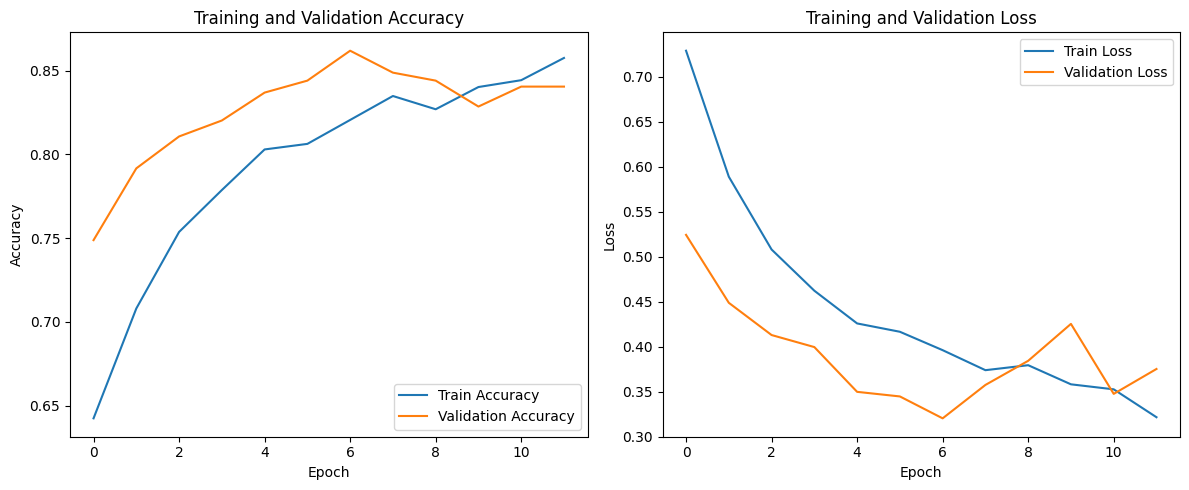

In [31]:
history_dict = history.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [32]:
# Evaluate the model on the test set
print("\nEvaluating model on test data:\n")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8526 - loss: 0.3074
Test Loss: 0.33906516432762146
Test Accuracy: 0.8500000238418579
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step
Confusion Matrix:
[[395  25]
 [101 319]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       420
           1       0.93      0.76      0.84       420

    accuracy                           0.85       840
   macro avg       0.86      0.85      0.85       840
weighted avg       0.86      0.85      0.85       840



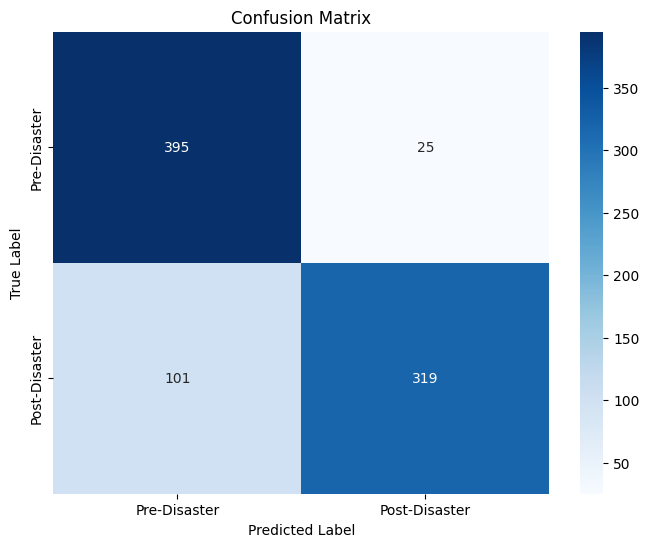

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pre-Disaster', 'Post-Disaster'], yticklabels=['Pre-Disaster', 'Post-Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Save as a Keras model (Native Keras format)
model.save('Damage_No_Damage_Binary_Classification_Model.keras')  

# Save as a .h5 file (HDF5 format), explicitly including the optimizer
model.save('Damage_No_Damage_Binary_Classification_Model.h5', include_optimizer=True)  

# Export as TensorFlow SavedModel format (directory format)
model.export('Damage_No_Damage_Binary_Classification_Model')

Saved artifact at 'Damage_No_Damage_Binary_Classification_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_427')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135213670391072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668353296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668357520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668356816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668354880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668359984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668366320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668364032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668364736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135213668632176: TensorSpec(shape=(), dtype=tf.resou

In [ ]:
#from tensorflow.keras.models import load_model

# Load the model
#model = load_model('MODEL FILE NAME')

In [ ]:
# Function to preprocess the image and make predictions
def predict_class(image):
    # Convert the PIL image to a NumPy array
    image = np.array(image)
    
    # Resize the image to match the input shape of the model (224x224)
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image
    image = image / 255.0
    
    # Add batch dimension (since model expects input shape (1, 224, 224, 3))
    image = np.expand_dims(image, axis=0)  # Shape: (1, 224, 224, 3)

    # Make the prediction using the model
    prediction = model.predict(image)

    # Get the class label based on the predicted probability
    class_label = "Post-Disaster" if prediction[0] < 0.5 else "Pre-Disaster"
    
    return class_label

# Create the Gradio interface for inference
interface = gr.Interface(
    fn=predict_class, 
    inputs=gr.Image(type="pil"),  # Accepts an image input in PIL format
    outputs="text",  # Outputs the predicted class as text
    title="Disaster Damage Classifier",
    description="Upload an image to classify it as Pre-Disaster or Post-Disaster."
)

# Launch the interface
interface.launch()
#iface.launch(share=True, show_error=True, debug=True)

In [ ]:
# The retrain model part is commented out for now. Uncomment and complete it as needed.
# def retrain_model(flagged_data_dir):
#     datagen = ImageDataGenerator(rescale=1./255)
#     flagged_data = datagen.flow_from_directory(
#         flagged_data_dir,
#         target_size=(224, 224),
#         batch_size=16,
#         class_mode='binary'
#     )
#    
#     # Retrain the model with flagged data
#     model.fit(flagged_data, epochs=5)
#   
#     # Save the updated model
#     model.save('disaster_damage_denseNet121_updated.h5')